In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline  # this pipeline is the same from sklearn, but for imbalanced data
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, cross_validate

## Reading Data

In [2]:
DATA = '../data/customers_clustered.csv'
RANDOM_STATE = 42

In [3]:
df_clustered = pd.read_csv(DATA)

In [4]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Marital_Status       2212 non-null   object 
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   MntWines             2212 non-null   int64  
 7   MntFruits            2212 non-null   int64  
 8   MntMeatProducts      2212 non-null   int64  
 9   MntFishProducts      2212 non-null   int64  
 10  MntSweetProducts     2212 non-null   int64  
 11  MntGoldProds         2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   i

## Separating featuers and target columns

In [5]:
X = df_clustered.drop('Response', axis=1)
y = df_clustered['Response']

In [6]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Dependents,hasDependent,AcceptedCmpTotal,hasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,16-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2


In [7]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Response, dtype: int64

## Pipeline and grid search

- Build the pipeline with standard scaler, power transformation and min max scaler again
- use feature selection with ANOVA (this internally selects the best features according to F-value of ANOVA for classification tasks)
- use random under sampler (since our data is imbalanced with only 15% acceptance rate in the current campaing)
- And then perform grid search with the following parameters for model tuning.

Best k features according to ANOVA test: [10, 15, 20, 25]

Inverse of regularization strengh C: np.logspace(-2,2, 5)

Logistic regressor solver: ['lbfgs', 'liblinear', 'saga'],

Logistic regressor penalty: ['l2', 'l1', 'elastic net', None] 


In [8]:
one_hot_cols = [
    'Education',
    'Marital_Status',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp3',
    'AcceptedCmp4', 
    'AcceptedCmp5', 
    'AcceptedCmp1', 
    'AcceptedCmp2',
    'Complain',
    # 'Response', 
    'hasDependent', 
    'hasAcceptedCmp', 
    'AgeGroup'
]

standard_scaler_cols = [
    'Income',
    'Age',
    'NumTotalPurchases'
]

power_cols = [
    'MntWines', 
    'MntFruits', 
    'MntMeatProducts',
    'MntFishProducts', 
    'MntSweetProducts', 
    'MntGoldProds',
    'MntTotal', 
    'MntRegularProds',
    'NumDealsPurchases', 
    'NumWebPurchases', 
    'NumCatalogPurchases',
    'NumStorePurchases', 
    'NumWebVisitsMonth'
]

min_max_scaler_cols = [
    'Recency',
    'DaysSinceEnrolled',
    'YearsSinceEnrolled',
    'Dependents',
    'AcceptedCmpTotal'
]

In [9]:
X.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'DaysSinceEnrolled', 'YearsSinceEnrolled', 'Age',
       'AgeGroup', 'MntTotal', 'MntRegularProds', 'Dependents', 'hasDependent',
       'AcceptedCmpTotal', 'hasAcceptedCmp', 'NumTotalPurchases', 'cluster'],
      dtype='object')

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

preprocessing = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
        ('standard', StandardScaler(), standard_scaler_cols),
        ('min_max', MinMaxScaler(), min_max_scaler_cols),
        ('power', PowerTransformer(), power_cols)
    ]
)

pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
        ('random_under_sampler', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]
)

In [11]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Education',
                                                   'Marital_Status', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'hasDependent',
                                                   'hasAcceptedCmp',
                                                   'AgeGroup']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age',...
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds', 'MntTotal',
                                                   'MntRegularProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth'])])),
                ('feature_selection', SelectKBest()),
                ('random_under_sampler', RandomUnderSampler(random_state=42)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [12]:
pipeline[:-1].get_feature_names_out()

array(['one_hot_encoder__AcceptedCmp3_0',
       'one_hot_encoder__AcceptedCmp3_1',
       'one_hot_encoder__AcceptedCmp5_0',
       'one_hot_encoder__AcceptedCmp5_1',
       'one_hot_encoder__AcceptedCmp1_0',
       'one_hot_encoder__AcceptedCmp1_1',
       'one_hot_encoder__hasAcceptedCmp_0',
       'one_hot_encoder__hasAcceptedCmp_1', 'min_max__AcceptedCmpTotal',
       'power__NumCatalogPurchases'], dtype=object)

In [13]:
pipeline.named_steps

{'preprocessing': ColumnTransformer(transformers=[('one_hot_encoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['Education', 'Marital_Status', 'Kidhome',
                                   'Teenhome', 'AcceptedCmp3', 'AcceptedCmp4',
                                   'AcceptedCmp5', 'AcceptedCmp1',
                                   'AcceptedCmp2', 'Complain', 'hasDependent',
                                   'hasAcceptedCmp', 'AgeGroup']),
                                 ('standard', StandardScaler(),
                                  ['Income', 'Age', 'NumTotalPurchases']),
                                 ('min_max',...xScaler(),
                                  ['Recency', 'DaysSinceEnrolled',
                                   'YearsSinceEnrolled', 'Dependents',
                                   'AcceptedCmpTotal']),
                                 ('power', PowerTransformer(),
                                

In [14]:
param_grid = {
    'feature_selection__k': [10, 15, 20, 25],
    'model__C': np.logspace(-2,2, 5),
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__penalty': ['l2', 'l1', 'elastic net', None] 
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=['roc_auc', 'average_precision', 'accuracy'],
    refit='average_precision'
)

In [15]:
grid_search

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot_encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'Complain',
                                                                          'hasDependent',
                                                                          'hasAcceptedCmp',
                                                                          'AgeGroup']),
                                                                        ('standard',
                                                                         StandardSc...
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'model__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'model__penalty': ['l2', 'l1', 'elastic net', None],
                         'model__solver': ['lbfgs', 'liblinear', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

In [16]:
grid_search.fit(X, y)

c:\Users\IgorNunes\anaconda3\envs\ifood-data-analyst\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\IgorNunes\anaconda3\envs\ifood-data-analyst\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\IgorNunes\anaconda3\envs\ifood-data-analyst\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\IgorNunes\anaconda3\envs\ifood-data-analyst\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\IgorNunes\anaconda3\envs\ifood-data-analyst\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio paramete

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot_encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'Complain',
                                                                          'hasDependent',
                                                                          'hasAcceptedCmp',
                                                                          'AgeGroup']),
                                                                        ('standard',
                                                                         StandardSc...
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'feature_selection__k': [10, 15, 20, 25],
                         'model__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'model__penalty': ['l2', 'l1', 'elastic net', None],
                         'model__solver': ['lbfgs', 'liblinear', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

## Best hyperparameters, comparing metrics, etc

- found the k best features to be 25 features
- regularization strenght to be 10
- model penalty to be l1
- solver to be liblinear

In [17]:
grid_search.best_params_

{'feature_selection__k': 25,
 'model__C': 10.0,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

In [18]:
grid_search.best_score_

0.5846567801755344

In [19]:
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_average_precision')

In [20]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__k,param_model__C,param_model__penalty,param_model__solver,params,split0_test_roc_auc,...,std_test_average_precision,rank_test_average_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
220,0.093105,0.013779,0.020102,0.005458,25,10.0,l1,liblinear,"{'feature_selection__k': 25, 'model__C': 10.0,...",0.850568,...,0.077940,1,0.762980,0.805869,0.789593,0.778281,0.773756,0.782096,0.014635,19
216,0.100260,0.009896,0.018777,0.008948,25,10.0,l2,lbfgs,"{'feature_selection__k': 25, 'model__C': 10.0,...",0.850250,...,0.079382,2,0.767494,0.803612,0.791855,0.778281,0.776018,0.783452,0.012757,16
217,0.056708,0.006530,0.025919,0.007337,25,10.0,l2,liblinear,"{'feature_selection__k': 25, 'model__C': 10.0,...",0.849774,...,0.080470,3,0.765237,0.803612,0.794118,0.778281,0.773756,0.783001,0.013941,18
221,0.219421,0.062953,0.021988,0.007834,25,10.0,l1,saga,"{'feature_selection__k': 25, 'model__C': 10.0,...",0.850171,...,0.078766,4,0.760722,0.805869,0.789593,0.778281,0.773756,0.781644,0.015240,20
218,0.143922,0.031252,0.019228,0.007133,25,10.0,l2,saga,"{'feature_selection__k': 25, 'model__C': 10.0,...",0.849734,...,0.080120,5,0.767494,0.803612,0.794118,0.778281,0.773756,0.783452,0.013383,16


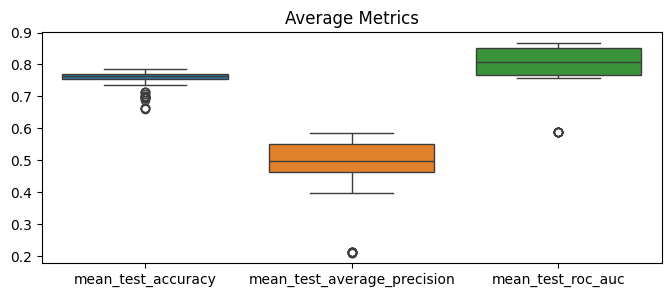

In [21]:
fig, ax = plt.subplots(figsize=(8,3))

sns.boxplot(data = results[['mean_test_accuracy', 'mean_test_average_precision', 'mean_test_roc_auc']], ax=ax)

ax.set_title('Average Metrics')

plt.show()

## Training logistic regression with the best hyperparameters



In [22]:
best_model = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('feature_selection', SelectKBest(score_func=f_classif, k=grid_search.best_params_['feature_selection__k'])),
        ('random_under_sampler', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('model', LogisticRegression(
            random_state=RANDOM_STATE, 
            max_iter=1000,
            C=grid_search.best_params_['model__C'],
            penalty=grid_search.best_params_['model__penalty'],
            solver=grid_search.best_params_['model__solver'],
        )
        )
    ]
)

scores =  cross_validate(
    estimator=best_model,
    X=X,
    y=y,
    cv=skf,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'],
    n_jobs=-1
)

In [23]:
scores['time'] = scores['fit_time'] + scores['score_time']

In [24]:
results_best_model = pd.DataFrame(scores)
results_best_model

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,0.225170,0.040873,0.783296,0.389313,0.761194,0.868371,0.577897,0.266043
1,0.143745,0.030304,0.796840,0.404959,0.731343,0.833538,0.628064,0.174049
2,0.193835,0.040315,0.794118,0.404762,0.761194,0.853075,0.538425,0.234150
3,0.199409,0.030842,0.800905,0.416667,0.833333,0.898493,0.674345,0.230251
4,0.218584,0.033094,0.825792,0.451327,0.772727,0.899339,0.669715,0.251678


Text(0.5, 1.0, 'Metrics best logistic regression')

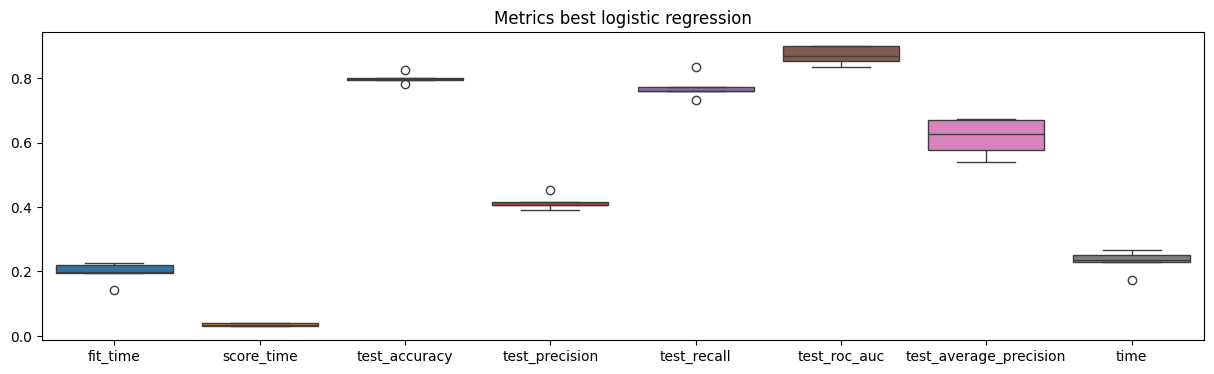

In [25]:
fig, ax = plt.subplots(figsize=(15, 4))

sns.boxplot(data=results_best_model, ax=ax)

ax.set_title('Metrics best logistic regression')

## What are the most important features?

- We compare the most important features to this model using the weights associated and plot a chart in the end

In [26]:
best_model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Education',
                                                   'Marital_Status', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'hasDependent',
                                                   'hasAcceptedCmp',
                                                   'AgeGroup']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age',...
                                                   'MntGoldProds', 'MntTotal',
                                                   'MntRegularProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth'])])),
                ('feature_selection', SelectKBest(k=25)),
                ('random_under_sampler', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(C=10.0, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [27]:
weight_feature = pd.DataFrame(
    {
        'feature': best_model[:-1].get_feature_names_out(),
        'weight': best_model['model'].coef_[0]
    }
).sort_values(by='weight', ascending=False, key=abs)

<Axes: xlabel='weight', ylabel='feature'>

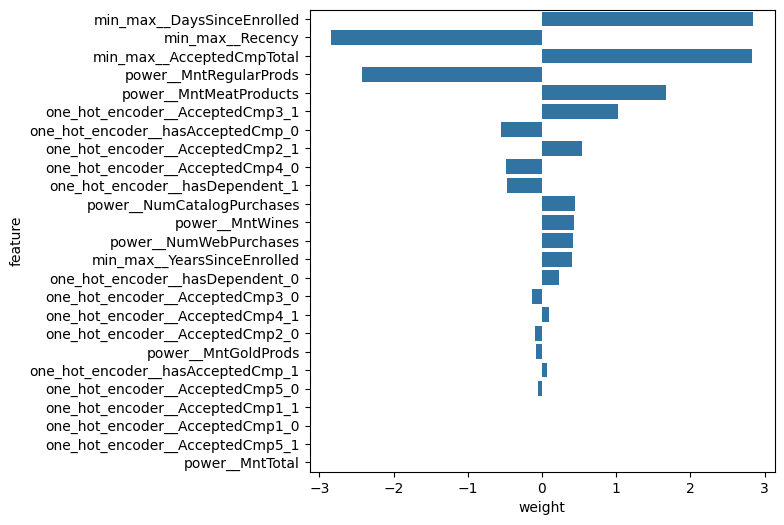

In [28]:
fig, ax = plt.subplots(figsize=(6,6))

sns.barplot(data=weight_feature, y='feature', x='weight', ax=ax)